# Procrastinate Pro+

## Details:

Over the past few months, the business has been constantly losing money - a lot of money has been invested in attracting users, but there is no result. I need to understand the reasons for this situation.

We have at our disposal a server log with data on application visits by new users who registered in the period from 2019-05-01 to 2019-10-27, uploading their purchases for this period, as well as statistics on advertising costs. We have to study how people use the product, when they start buying, how much money each customer brings in, when it pays off, and what factors negatively affect user acquisition.

We have 3 datasets with data on visits, orders and expenses:


 -   /datasets/visits_info_short.csv. Скачать датасет
 -   /datasets/orders_info_short.csv. Скачать датасет
 -   /datasets/costs_info_short.csv. Скачать датасет
 


### Questions:


- What countries do the visitors come from? Which countries have the most paying users?
- What devices do they use? What devices do paying users use most often?
- What advertising channels did you use to attract users? Which channels bring in the most paying users?

###  Marketing


- How much money did was spent? Total / per source / by time
- How much did it cost on average to attract one buyer from each source?

### Estimate the ROI of ads to attract users


- Analyze the overall payback of advertising;
- Analyze advertising ROI by device;
- Analyze advertising ROI by country;
- Analyze advertising ROI broken down by advertising channel.

#### Questions

- Does advertising aimed at attracting users in general pay off?
- What devices, countries and advertising channels can have a negative impact on advertising ROI?
- What can cause payback problems? Explore conversion and retention by device, country, advertising channel.

It is generally accepted in the organization that payback should occur no later than 2 weeks after attracting users.


### Conclusions

- Highlight the reasons for the inefficiency of attracting users;
- Form recommendations for the marketing department to improve efficiency.



### Data Description
The visits_log_short table (server log with information about site visits):

    User Id - unique user identifier
    Device — user device category
    Session start - date and time of the session start
    Session End - date and time the session ends
    Channel - identifier of the advertising source from which the user came
    Region - user's country

Table orders_log_short (information about orders):

    User Id - unique id of the user who made the order
    Event Dt - date and time of purchase
    revenue

Table costs_short (information about marketing costs):

    Channel - advertising source identifier
    Dt - date
    Costs - the cost of this advertising source on this day

##  Download data and prepare it for analysis


In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [61]:
visits = pd.read_csv('/datasets/visits_info_short.csv') #website visits
orders = pd.read_csv('/datasets/orders_info_short.csv') #orders
costs = pd.read_csv('/datasets/costs_info_short.csv') #ad costs

Firstly let's check `visits`

In [62]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [63]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Let's change column names for convenience

In [64]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits.head(1)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01


Let's change data type to date

In [65]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Duplicates check

In [66]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [67]:
visits['channel'].unique()


array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [68]:
visits.duplicated().sum()

0

We checked the most important ones, there are no duplicates, it makes no sense to check in other columns, since there are many values and they are all different. I assume that `user_id` can be repeated, but this is normal, because one person can visit the site more than once

Let's move to `orders`

In [69]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [70]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Change the columns name

In [71]:
orders.columns = ['user_id', 'event_dt', 'revenue']
orders.head(1)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99


Change the data type

In [72]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [73]:
orders.duplicated().sum()

0

There are no duplicates here either, the values in the columns are the same, everything is fine

Let's study `costs`

In [74]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [75]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Let's change colmn names and data type

In [76]:
costs.columns = ['dt', 'channel', 'costs']
costs.head(1)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3


In [77]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [78]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [79]:
costs.duplicated().sum()

0

Everything's also good here

We changed the data types to date where it required it, changed the column names for convenience, and checked for duplicate content.

## Functions

I'm gonna create some functions, so it's easier to do the analysis. 
The function are gonna calculate users' profiles, retention, conversion, LTV and ROI. 

In [80]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

First, let's create a function for creating user profiles, let's call it `get_profiles`

In [81]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # finding the parameters of the first visits
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # for cohort analysis, we determine the date of the first visit
    # and the first day of the month in which this visit occurred
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # adding a sign of paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # adding flags for all events from event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # counting the number of unique users
    # with the same source and date of attraction
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # combining advertising spending and the number of attracted users
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # dividing advertising costs by the number of attracted users
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # adding acquisition cost to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # the cost of organic user acquisition is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Adding a function to calculate retention

In [82]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # adding the payer column to the passed dimensions list
    dimensions = ['payer'] + dimensions

    # excluding users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # collecting "raw" data to calculate retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # function for grouping a table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # getting retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # getting a table of retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

Adding a function to calculate the conversion

In [83]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # excluding users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determining the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # adding purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculating lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # function for grouping a table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide each "cell" in the row by the size of the cohort
        # and get the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # getting a conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # for the conversion dynamics table, remove 'cohort' from dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # getting a table of conversion dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

Writing a function to calculate LTV and ROI

In [84]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # excluding users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # adding purchase data to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calculating the user's lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # grouping function according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        # making a "triangular" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # finding the amount of revenue with accumulation
        result = result.fillna(0).cumsum(axis=1)
        # calculating cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # combining cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculating LTV: dividing each “cell” in the row by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)
        # excluding all lifetimes that exceed the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restoring cohort sizes
        result['cohort_size'] = cohort_sizes

        # collecting a dataframe with user data and CAC values,
        # adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # calculating the average CAC by parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculating ROI: dividing LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # removing rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # restoring cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # adding CAC to ROI table
        roi['cac'] = cac['cac']

        # in the final table we leave the sizes of cohorts, CAC
        # and ROI in lifetimes that do not exceed the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    # getting ROI and LTV tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # for dynamics tables removing 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # getting tables of LTV and ROI dynamics
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,  # LTV table
        result_in_time,  # LTV dynamics table
        roi_grouped,  # ROI table
        roi_in_time,  # ROI dynamics table
    )

Let's also set a couple of functions for the subsequent visualization of our metrics

In [85]:
# frame smoothing function

def filter_data(df, window):
    # for each column apply a moving average
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [86]:
# function to visualize retention

def plot_retention(retention, retention_history, horizon, window=7):

    # setting the grid size for charts
    plt.figure(figsize=(15, 10))

    # excluding cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # in the table of dynamics leaving only the necessary lifetime
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # if there is only payer in the indexes of the hold table,
    # add the second feature - cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Paying users retention')

    
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Non-paying users retention')

    
    ax3 = plt.subplot(2, 2, 3)
    
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title(
        'Dynamics of retention of paying users on the {}-th day'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title(
        'Dynamics of retention of non-paying users on the {}-th day'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [87]:
# function to visualize the conversion

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # setting the grid size for charts
    plt.figure(figsize=(15, 5))

    # excluding cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # in the table of dynamics leaving only the necessary lifetime
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first graph - conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    # second graph - the dynamics of conversion
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('Dynamics of user conversion on the {}-th day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [88]:
# function to visualize LTV and ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # setting the grid size for charts
    plt.figure(figsize=(20, 10))

    # from ltv table excluding cohort sizes
    ltv = ltv.drop(columns=['cohort_size'])
    # in the ltv table of dynamics leaving only the necessary lifetime
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # putting the cost of attraction in a separate frame
    cac_history = roi_history[['cac']]

    # from roi table excluding cohort sizes and cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # in the roi table of dynamics leaving only the necessary lifetime
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # first graph - ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # second graph - the dynamics of ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User LTV dynamics on the {} day'.format(horizon))

    # third graph - the dynamics of cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)

    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('User Acquisition Cost Dynamics')

    # fourth graph - roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # fifth graph - the dynamics of roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Acquisition date')
    plt.title('User LTV dynamics on the {} day'.format(horizon))

    plt.tight_layout()
    plt.show()

## Exploratory data analysis


- What countries do the visitors come from? Which countries have the most paying users?
- What devices do they use? What devices do paying users use most often?
- What advertising channels did you use to attract users? Which channels bring in the most paying users?

Getting user profiles

In [89]:
profiles = get_profiles(visits, orders, events = None, ad_costs = costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [90]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [91]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

In [92]:
profiles['region'].unique()

array(['United States', 'France', 'Germany', 'UK'], dtype=object)

In [93]:
profiles.groupby('region').agg({'user_id': 'nunique'})

,user_id
region,
France,17450
Germany,14981
UK,17575
United States,100002


In [94]:
profiles.groupby('region').agg({'payer':'mean'}).sort_values(by = 'payer', ascending = False)

,payer
region,
United States,0.069019
Germany,0.041119
UK,0.039829
France,0.037994


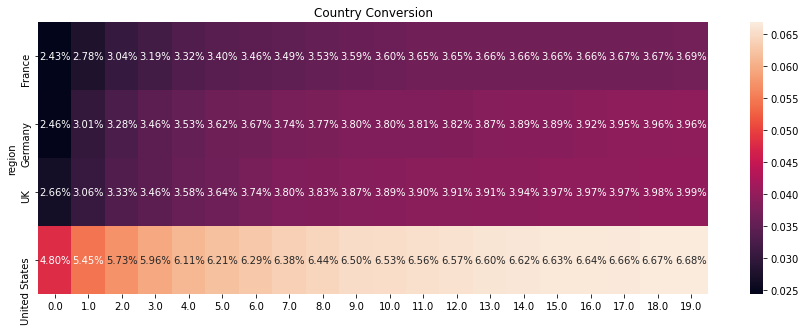

In [95]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 10, 10).date(), 20, dimensions=['region']
)


plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Country Conversion')
plt.show()

Most users come from the US - a little over 100K, from France and the UK about the same number, 17.5K, and the least people come from Germany - 15K

The conversion shows that over the past month, the majority of paying users came from the US. Moreover, initially they apparently just go into the application and only after 3-4 days of use they begin to actively purchase a subscription.

In [96]:
profiles['device'].unique()

array(['Mac', 'iPhone', 'PC', 'Android'], dtype=object)

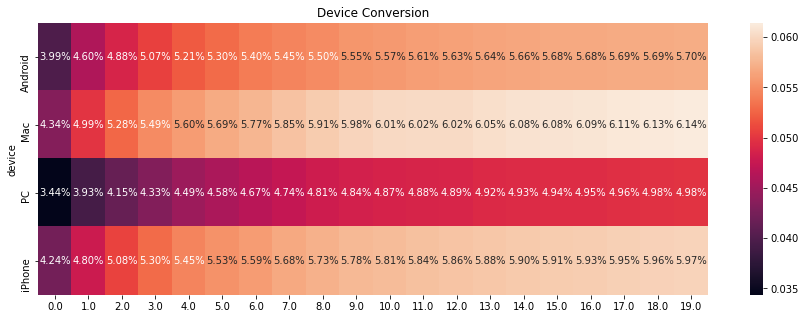

In [97]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 10, 10).date(), 20, dimensions=['device']
)


plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Device Conversion')
plt.show()

The application is mainly accessed from smartphones and macs. Moreover, the conversion on the 19th day of the life of users on mac is the highest - 6.14%. It is worth paying attention to the mobile application, it may be difficult for users to understand it at first, since the conversion in the first days of life is quite low

In [98]:
profiles['channel'].unique()

array(['FaceBoom', 'organic', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

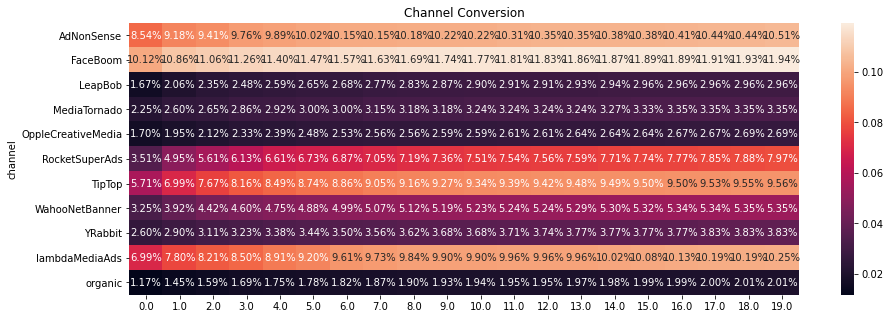

In [99]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 10, 10).date(), 20, dimensions=['channel']
)

plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Channel Conversion')
plt.show()

Recently, the most successful campaigns have been at `FaceBoom`, `AdNonSense`, `lambdaMediaAds` and `TipTop`. 11.94%, 10.51%, 10.25% and 9.56% of users came from them, respectively. There were also failed campaigns. For example, insolvent users themselves come through `LeapBob` and `OppleCreativeMedia`. It’s also worth working on organic user acquisition. Perhaps discounts or promotional codes for friends of existing users will help.

## Marketing

- How much money did was spent? Total / per source / by time
- How much did it cost on average to attract one buyer from each source?

In [100]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [101]:
costs['costs'].sum()

105497.30000000002

Total spent on advertising: `105497.3`

In [102]:
by_chan = costs.groupby('channel').agg({'costs':'sum'})
by_chan

,costs
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


Text(0, 0.5, 'Sum')

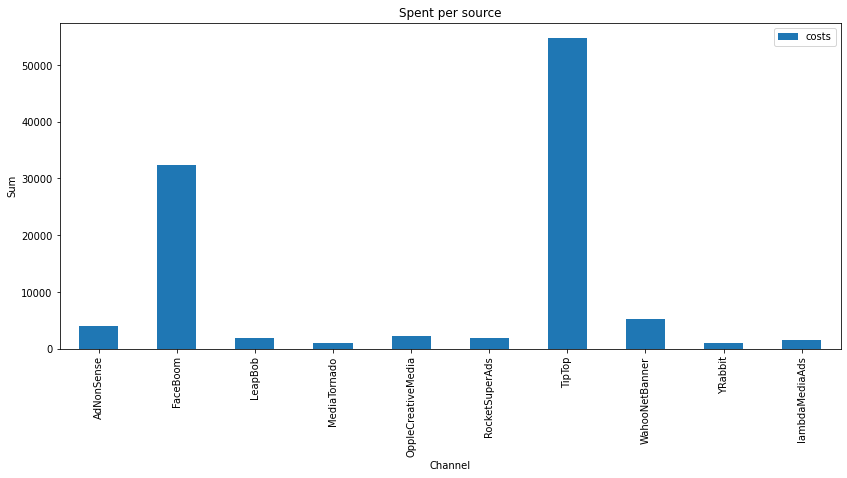

In [103]:
by_chan.plot(kind='bar', figsize = (14,6))
plt.title('Spent per source')
plt.xlabel('Channel')
plt.ylabel('Sum')

Most of all invested in advertising `FaceBoom` and `TipTop`: 32445K and 54751K respectively. Advertising in `YRabbit` and `MediaTornado` cost the cheapest - up to 1000. Returning to the conversion, I would like to note that advertising in `FaceBoom` justified itself, since most of the solvent users came from it. It is worth paying attention to the sources `AdNonSense` and `lambdaMediaAds`, they have excellent conversion, although the contributions to advertising were not even that big.

In [104]:
first = costs
first['dt'] = pd.to_datetime(first['dt']).dt.month
second = pd.pivot_table(first, values='costs', 
                                index='dt', 
                                columns='channel',
                                aggfunc='sum'
                                )
second

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
dt,,,,,,,,,,
5,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4
6,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2
7,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2
8,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0
9,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2
10,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6


Text(0, 0.5, 'Sum')

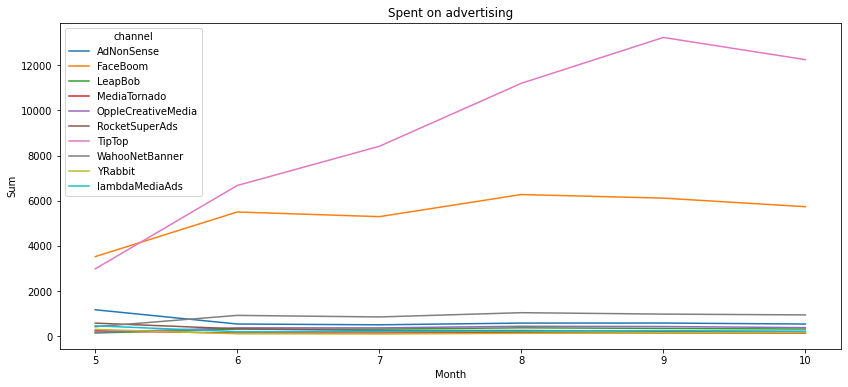

In [105]:
second.plot(figsize = (14,6))
plt.title('Spent on advertising')
plt.xlabel('Month')
plt.ylabel('Sum')

Basically, advertising was conducted on two sources: `TipTop` and `FaceBoom`. They invested in Tiptop during all 5 months, with the largest amount invested in September. They invested in Facebook evenly every month.

In [106]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [107]:
third = profiles[profiles['payer'] == True]
new = third.groupby('channel').agg({'acquisition_cost':'mean'})
new

,acquisition_cost
channel,
AdNonSense,1.011119
FaceBoom,1.113243
LeapBob,0.210378
MediaTornado,0.217389
OppleCreativeMedia,0.250456
RocketSuperAds,0.418493
TipTop,2.785961
WahooNetBanner,0.600576
YRabbit,0.211338


Text(0, 0.5, 'Average cost')

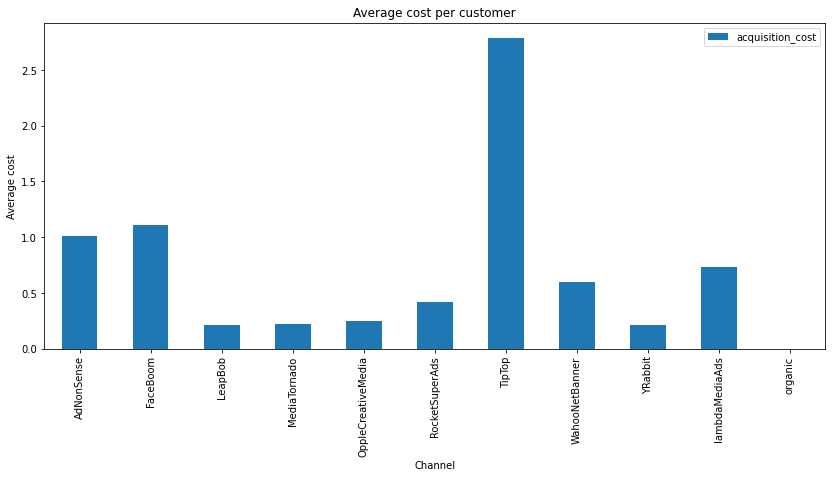

In [108]:
new.plot(kind='bar', figsize = (14,6))
plt.title('Average cost per customer')
plt.xlabel('Channel')
plt.ylabel('Average cost')

The most expensive buyers come from `TipTop`, the average cost of a buyer there is 2.7, buyers from such sources as `AdNonSense` and `FaceBoom` also turned out to be quite expensive. There, the cost of one is slightly higher than 1.

## Estimating the ROI of advertising to attract users

- Analyze the overall payback of advertising;
- Analyze advertising ROI by device;
- Analyze advertising ROI by country;
- Analyze advertising ROI broken down by advertising channel.

**Questions**

- Does advertising aimed at attracting users in general pay off?
- What devices, countries and advertising channels can have a negative impact on advertising ROI?
- What can cause payback problems? Explore conversion and retention by device, country, advertising channel.

It is generally accepted in the organization that payback should occur no later than 2 weeks after attracting users.

### total return on advertising

First, let's analyze the general situation.

Let's introduce 2 new indicators: the moment of analysis - November 1, 2019, and the horizon of analysis should be 14 days

And we will remove users who came organically, since we do not pay for them.

In [109]:
observation_date = datetime(2019, 11, 1).date()  # moment of analysis
horizon_days = 14  # horizont of analysis

In [110]:
new_prof = profiles[profiles['channel'] != 'organic']
new_prof['channel'].unique()

array(['FaceBoom', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

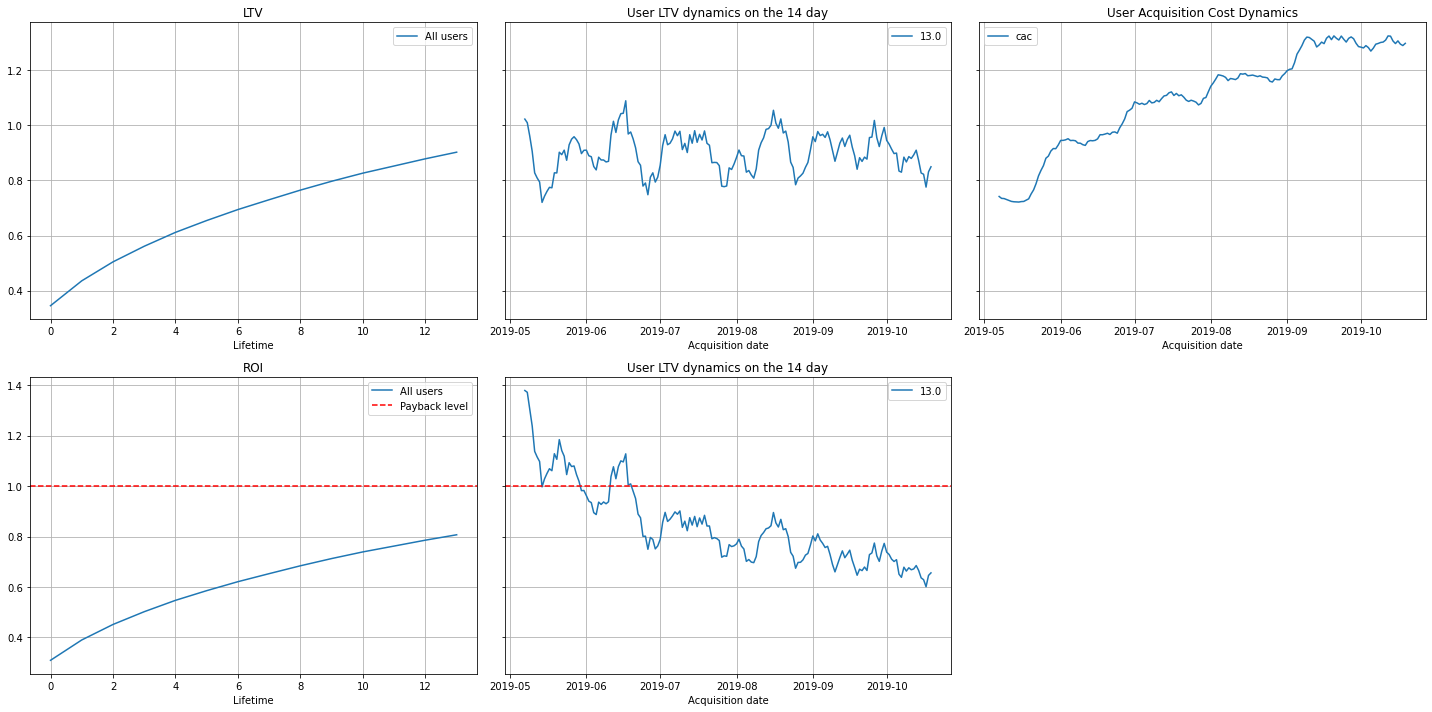

In [111]:
# LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_prof, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

The following conclusions can be drawn from the graphs:

- Advertising does not pay off. ROI at the end of 2 weeks reaches only 80%.
- CAC is constantly growing, which is not very good. This means that by November the user has become more expensive by almost 50%.
- Our LTV is stable, but rather low.
- LTV and ROI jumps in the middle of almost every month, apparently that's when advertising campaigns are carried out

To understand the reasons, let's go through all the available user characteristics - country, source and device of the first visit.

Let's start with a breakdown by country: pass the `region` column to the `dimensions` parameter.

### Advertising ROI by country

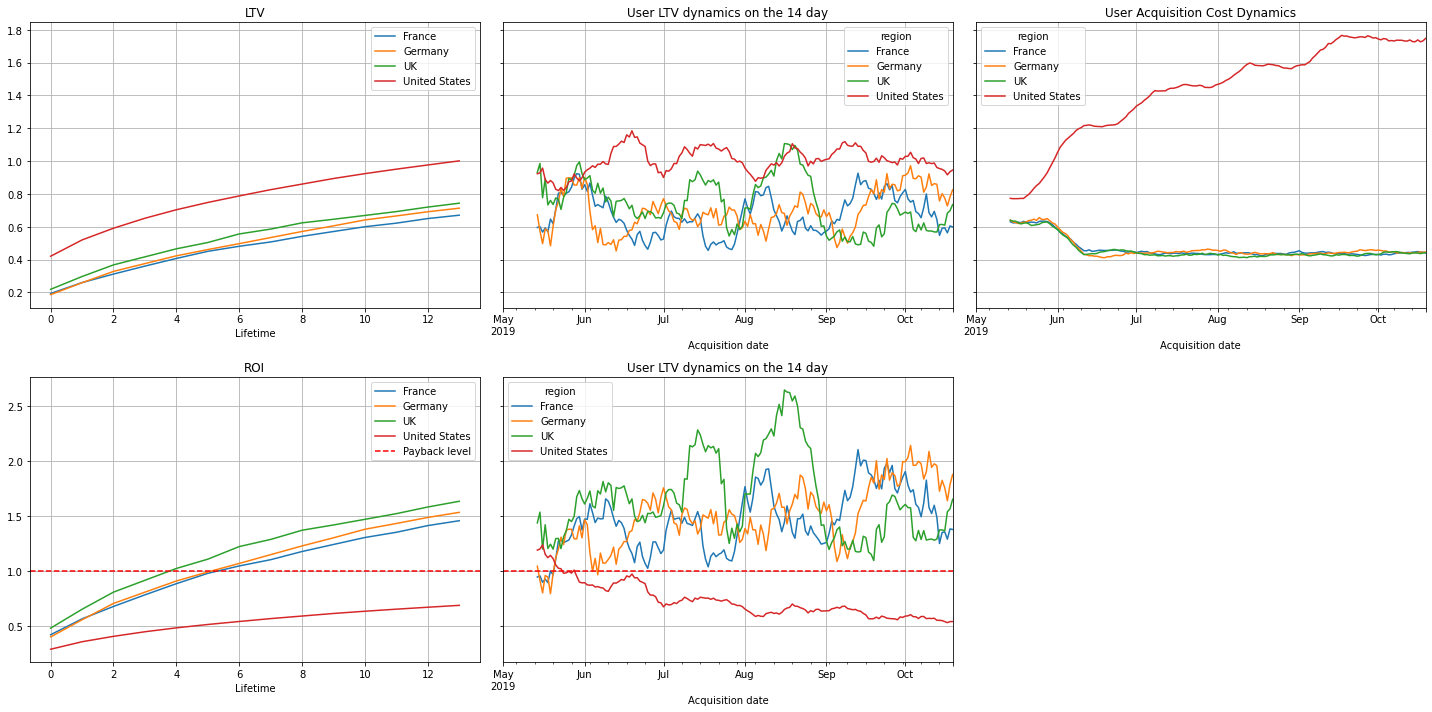

In [112]:

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_prof, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

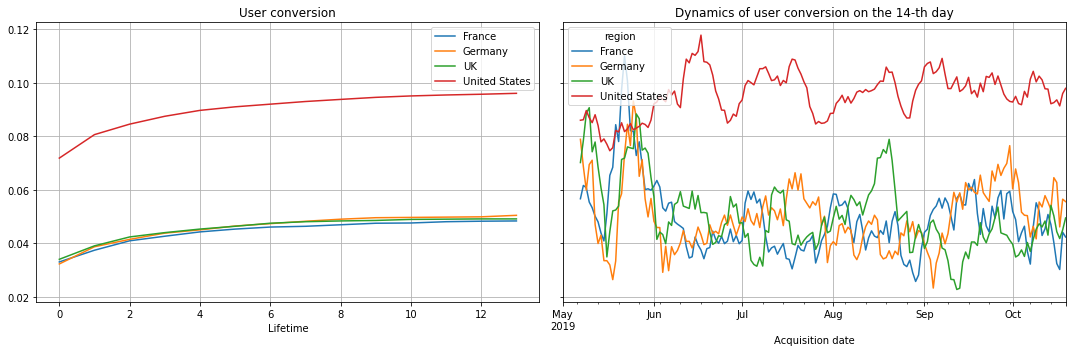

In [113]:
# conversion by country

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    new_prof, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

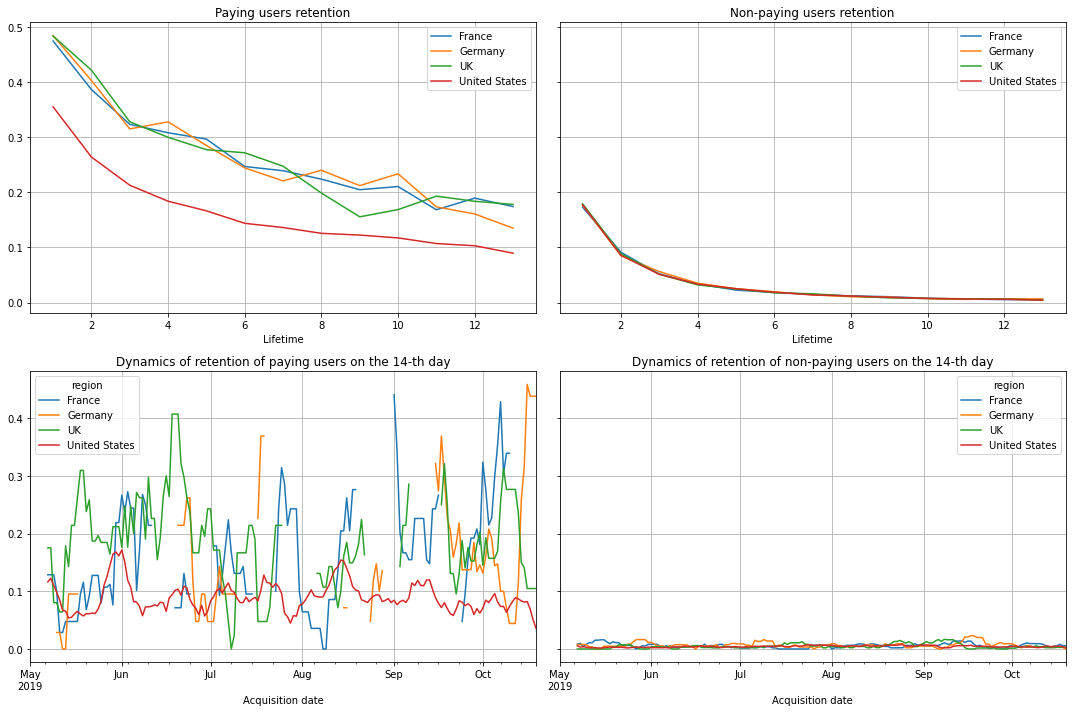

In [114]:
# retention by country

retention_raw, retention_grouped, retention_history = get_retention(
    new_prof, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Here you can clearly see the reason for this situation by country. As we found out earlier, most users come from the USA - 100K, while the rest of the countries of users have 15-17K each.

Looking at the graphs, you can see that the USA turned out to be the most failed option, despite the fact that they have the highest light time:
- Advertising in the USA does not pay off at all, ROI reaches only 70-80%. While in other countries advertising campaigns are very successful. The most successful campaigns take place in the UK, where the ROI is slightly above 200%
- Obviously, this was not always the case, until about July there were successful advertising campaigns in the USA, and then the company probably began to try new promoters and ROI fell sharply and is still falling. While in Europe advertising campaigns performed well throughout the period
- Despite the poor payback in the US, the price tag per user there is growing by leaps and bounds. The CAC in the US is the highest of all countries, and the cost per user in the US is many times higher than in Europe. The price tag began to grow so rapidly as races from the end of May.
- Judging by the conversion rates, US users are converting very well throughout the period
- But despite the good conversion, the retention of users from the US is quite poor, perhaps the reason is the lack of some application features for this region
- To improve the performance of the application, I recommend that you review this region and put special emphasis on it, since the United States gives a lot of hope.

Obviously, we found a problem in the US, but why exactly is not yet clear. Therefore, study the sources of attracting `channel`. Perhaps the payback is affected by unsuccessful advertising in any one channel.

### Advertising ROI by channel

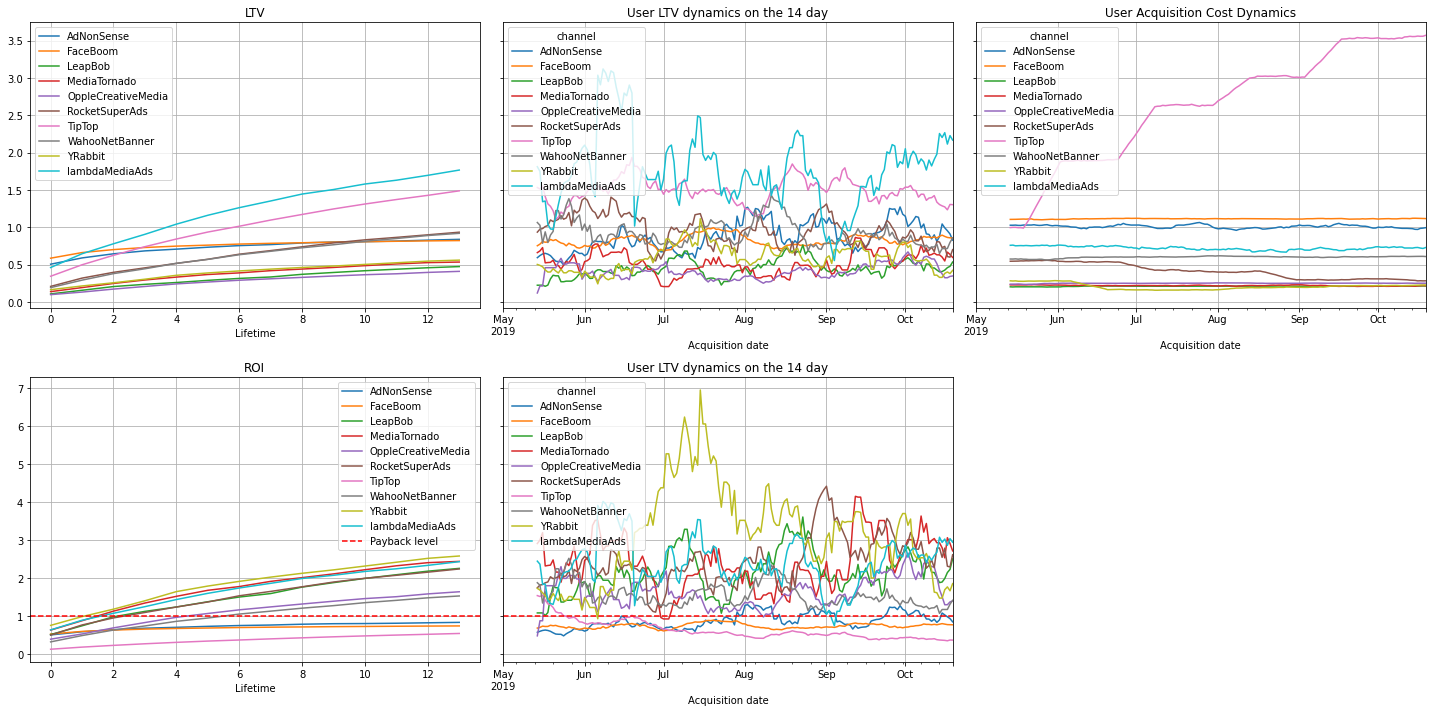

In [115]:
# ltv, roi

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_prof, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

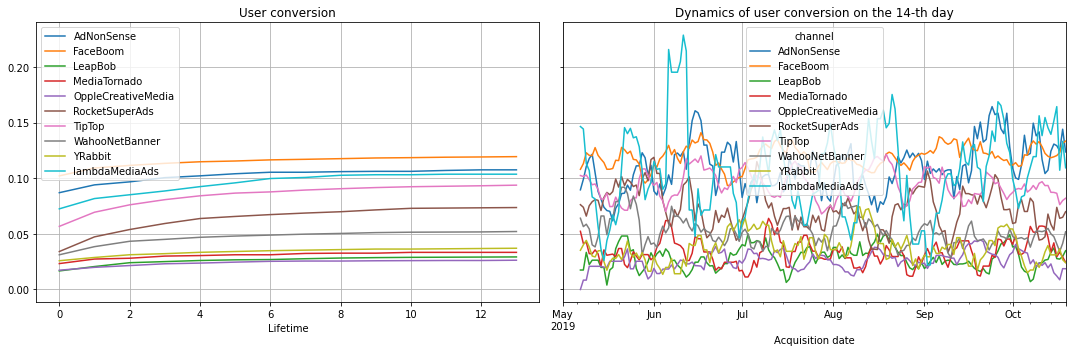

In [116]:
# conversion

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    new_prof, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

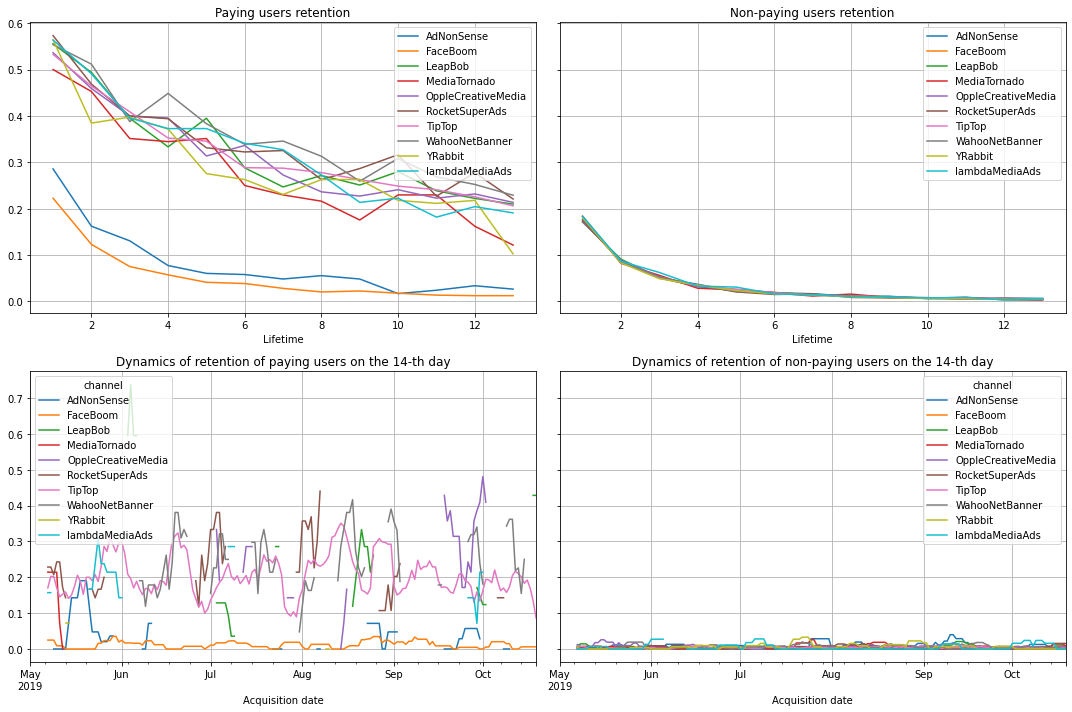

In [117]:
# retention

retention_raw, retention_grouped, retention_history = get_retention(
    new_prof, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

- As I suspected, it's `TipTop`. Despite the fact that this source gives a fairly stable lifetime, although not the best, users from this source do not pay off at all. The dynamics of `TipTop` payback continues to fall and tend to 50% to the bottom. While the amount of investment in this source is huge, many times higher than other sources.
- I also want to note `FaceBoom` and its stability. In the past, when we looked at advertising, Facebook showed excellent results, although now it is noticeable that this source is not paying off.
- I want to pay attention to such sources as `YRabbit` and `lamdaMediaAds`. They have excellent ROI and LVT, despite the fact that their costs are quite low.
- Users from `FaceBoom` and `AdNonSense` convert the best, while their retention is very low. Perhaps there is an error in the operation of the advertisement itself and the user cannot take further actions.

Let's see how the situation with devices.

### Ad ROI by device

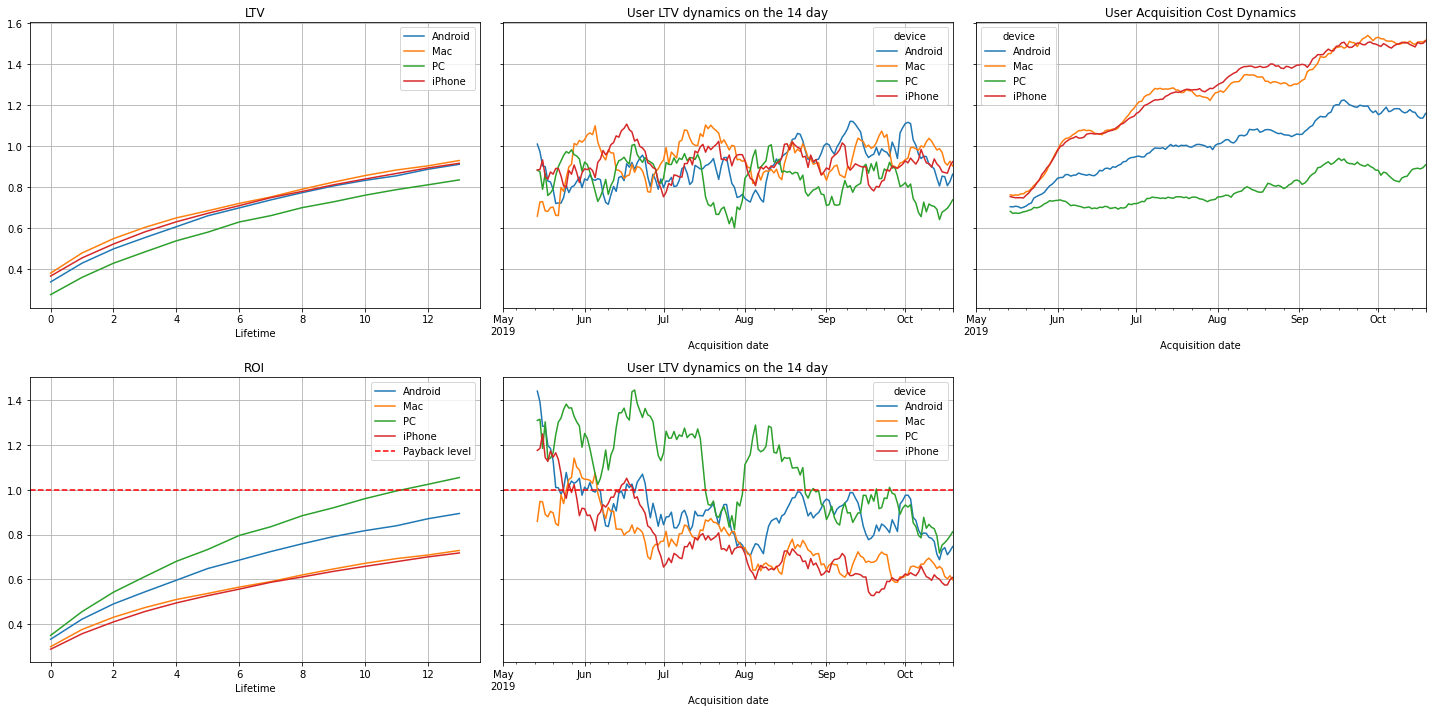

In [118]:
# ltv and roi

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_prof, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

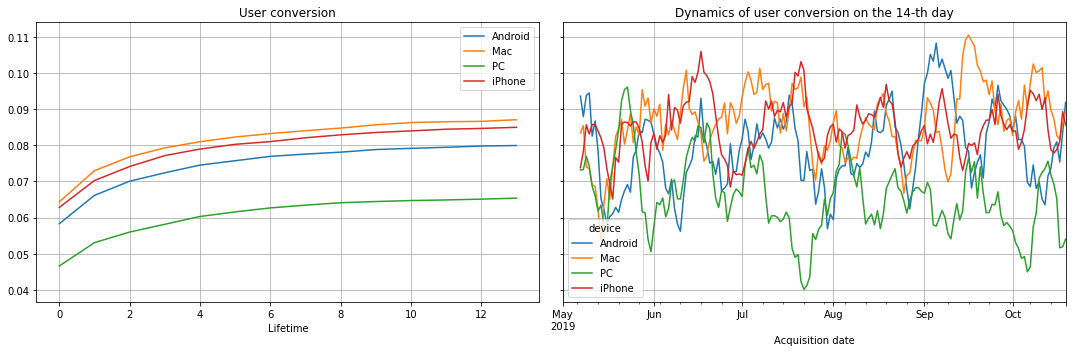

In [119]:
# conversion

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    new_prof, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

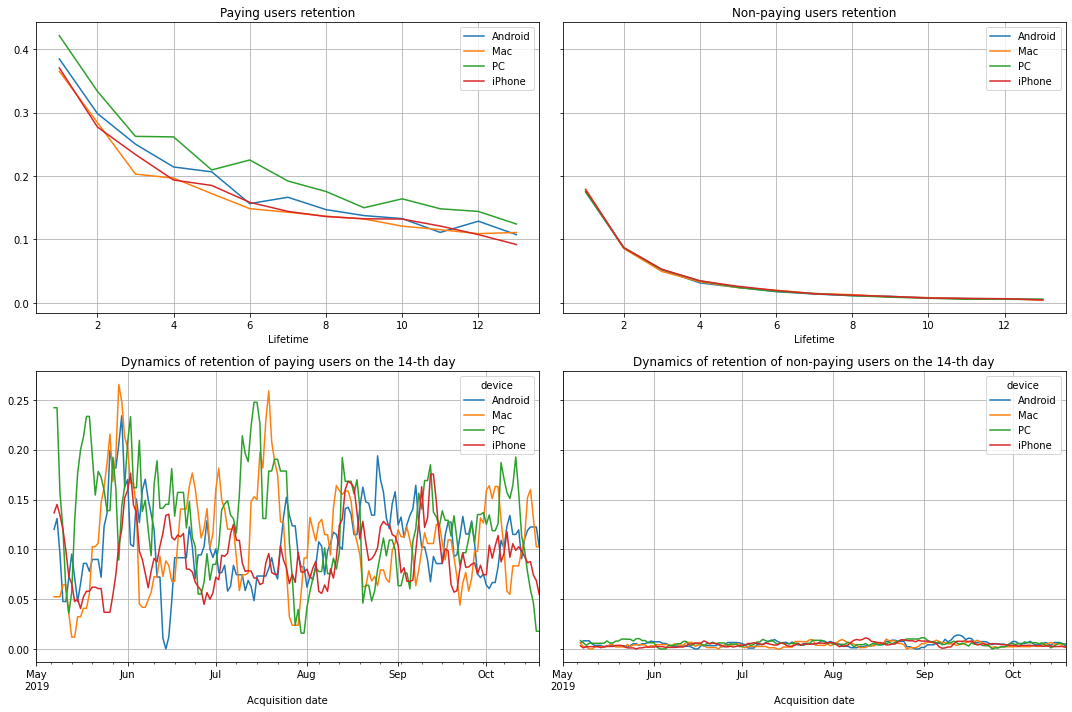

In [120]:
# retention

retention_raw, retention_grouped, retention_history = get_retention(
    new_prof, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

By devices, you can see that the situation is more stable.
- I just want to note that the payback of users coming from `Android` and `Mac` is quite low, about 85%, respectively, advertising on these devices does not pay off. While the costs of these devices are the highest.
- There is no question in the devices, the question depends more on the previous indicators
- The only thing I want to note in comparison is that those very expensive ads were carried out specifically for IOS devices, it needs to be corrected

## Сonclusion

**Conclusions:**

- The largest number of users is in the USA - more than 100K, in France and the UK about 17K and in Germany almost 15K.
- The most solvent users come from the USA.
- US conversion is the highest, although retention in this region is the lowest
- The application is mainly accessed from smartphones and ios devices.
- Lately, the most successful campaigns were held by `FaceBoom`, `AdNonSense`, `lambdaMediaAds` and `TipTop`. 11.94%, 10.51%, 10.25% and 9.56% of users came from them, respectively. Although, as further research showed, `TipTop` and `FaceBoom` do not pay back their investments.
- `FaceBoom` and `TipTop` invested the most in advertising: 32445K and 54751K respectively. Advertising in `YRabbit` and `MediaTornado` cost the cheapest - up to 1000. Returning to the conversion, I would like to note that advertising in `FaceBoom` justified itself, since most of the solvent users came from it. It is worth paying attention to the sources `AdNonSense` and `lambdaMediaAds`, they have excellent conversion, although the contributions to advertising were not even that big.
- The most expensive buyers come from `TipTop`, the average cost of a buyer there was 2.7
- Ads don't pay off and that's presumably because of `TipTop`, which accounted for most of the contributions that didn't pay off.
- The biggest price tag per user in the US, where advertising does not pay off
- Advertising does not pay off on devices such as `Android` and `Mac`.
- The most expensive ads - ads on IOS


**Recommendations:**

- It is worth paying attention to the mobile application. Conversion in the first days on smartphones is quite low, it may be difficult for users to understand it right away.
- To pay attention to the organic growth of buyers, perhaps discounts and promotional codes will help.
- I want to pay attention to such sources as `YRabbit` and `lamdaMediaAds`. They have excellent ROI and LVT, despite the fact that their costs are quite low.
- And the budget for `TipTop` is either reduced, or generally found a new advertising company
- Most of the users come from the USA, so it's worth finding more successful advertising agencies
- Promote advertising in Europe, as the ROI there has been excellent throughout the entire period. Perhaps it makes sense to cut the US budget and invest it in Europe.
- To improve the performance of the application, I recommend that you review this region and put special emphasis on it, since the United States gives a lot of hope.
- Users from `FaceBoom` and `AdNonSense` convert the best, while their retention is very low. Perhaps there is an error in the operation of the advertisement itself and the user cannot take further actions.
- Pay attention to ads on iOS devices